### Import Packages

In [1]:
import pandas as pd
import numpy as np
import os
from PIL import Image
from tqdm import tqdm
import torch
from transformers import ViTImageProcessor, ViTForImageClassification
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from transformers import AdamW, get_linear_schedule_with_warmup
import torch.nn as nn

### Image and Labels Loading and Matching

In [2]:
# Load the Data from CSV
csv_file = "clean_MovieGenre.csv"  # Path to your CSV file
df = pd.read_csv(csv_file)

# Specify the binarized columns
binarized_columns = ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 
                     'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History', 'Horror', 'Music', 'Musical', 
                     'Mystery', 'Romance', 'Sci-Fi', 'Short', 'Sport', 'Thriller', 'War', 'Western']

In [3]:
image_folder = "sample_images" #sample_images for developing, downloaded_images for final
images = []
labels = []
batch_size = 128  

# Load images and labels in batches
num_batches = len(df) // batch_size + 1

for batch_num in tqdm(range(num_batches)):
    start_idx = batch_num * batch_size
    end_idx = min((batch_num + 1) * batch_size, len(df))
    
    batch_df = df.iloc[start_idx:end_idx]
    batch_images = []
    batch_labels = []
    
    for index, row in batch_df.iterrows():
        filename = str(row.iloc[0]) + ".jpg"  # filenames match the imdbIDs
        label = [int(row[column]) for column in binarized_columns]  # Extract binarized labels for each genre

        image_path = os.path.join(image_folder, filename)
        try:
            image = Image.open(image_path)  # Open image using PIL
            image = image.convert("RGB")  # Convert image to RGB mode if necessary
            image = image.resize((224, 224))  # Resize image to 224x224
            image_array = np.array(image)  # Convert PIL Image to numpy array
            batch_images.append(image_array)
            batch_labels.append(label)
        except Exception as e:
            pass
    # Concatenate the batches of images and labels
    if batch_images:
        images.append(np.array(batch_images))
        labels.append(np.array(batch_labels))

# Concatenate all batches into single numpy arrays
if images:
    images = np.concatenate(images, axis=0)
    labels = np.concatenate(labels, axis=0)


100%|██████████| 260/260 [00:11<00:00, 22.14it/s]


### Sample Posters

Images shape: (2975, 224, 224, 3)
Labels shape: (2975, 23)


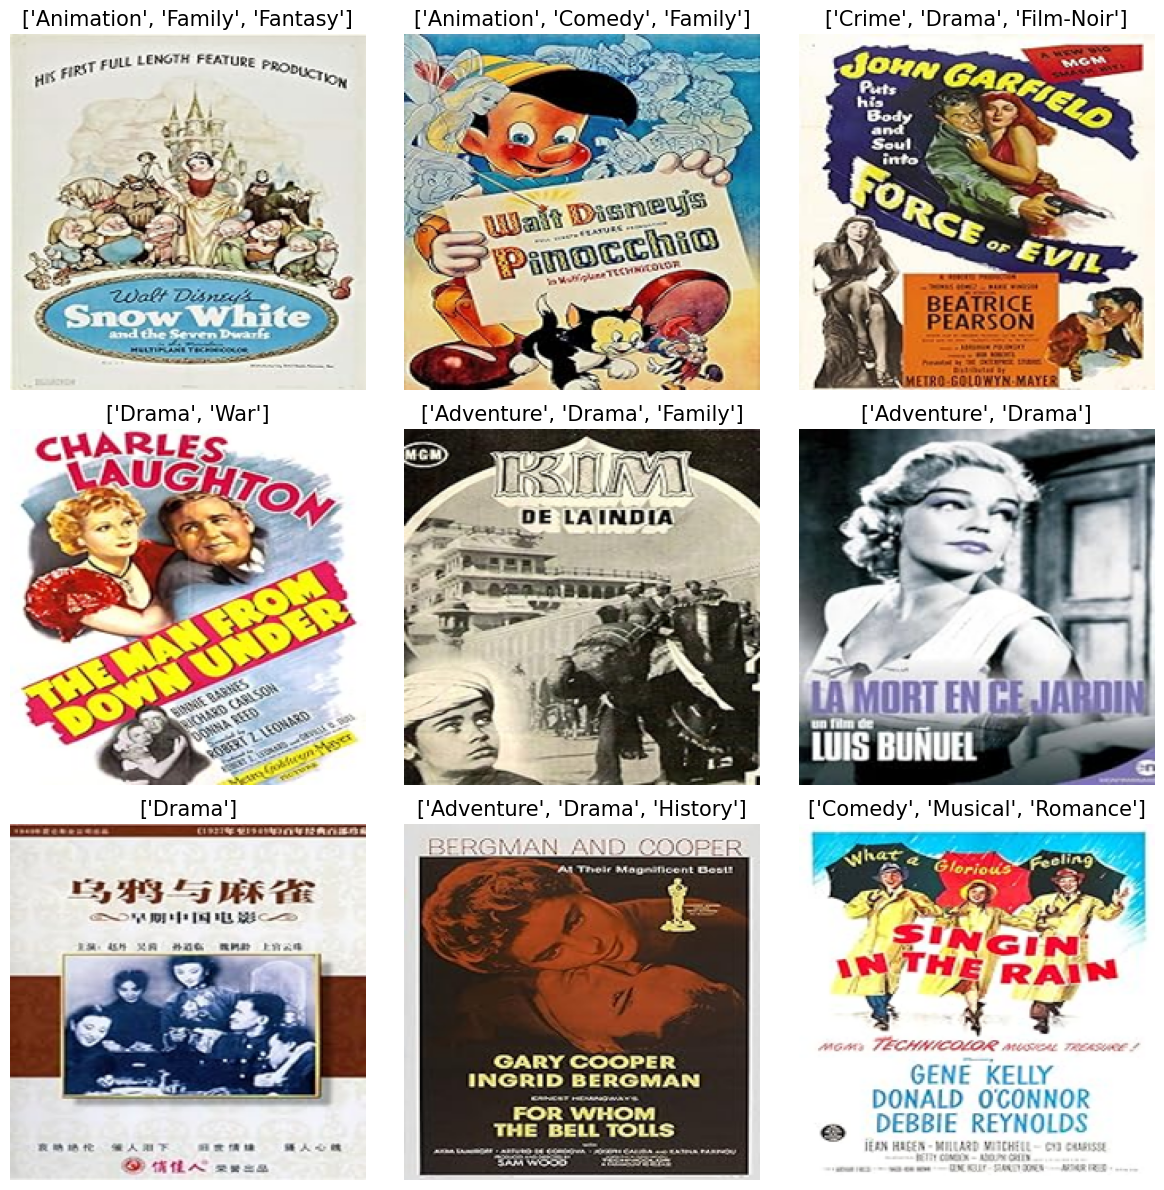

In [4]:
# Print the shapes of the loaded data
print("Images shape:", images.shape)
print("Labels shape:", labels.shape)

# Display sample images
plt.figure(figsize=(12, 12))
for i in range(9):
	ax = plt.subplot(3, 3, i + 1)
	plt.imshow(images[i])
	plt.axis('off')
	plt.title([column for column, label in zip(binarized_columns, labels[i]) if label == 1], fontsize=15)
plt.tight_layout()
plt.show()

### Preprocessing

In [5]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42) #change test_size if want quicker runtime

# Further split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Print the shapes of the split datasets
print("Training images shape:", X_train.shape)
print("Training labels shape:", y_train.shape)
print("Validation images shape:", X_val.shape)
print("Validation labels shape:", y_val.shape)
print("Testing images shape:", X_test.shape)
print("Testing labels shape:", y_test.shape)

Training images shape: (1904, 224, 224, 3)
Training labels shape: (1904, 23)
Validation images shape: (476, 224, 224, 3)
Validation labels shape: (476, 23)
Testing images shape: (595, 224, 224, 3)
Testing labels shape: (595, 23)


In [6]:
train_label_distribution = np.sum(y_train, axis=0)
val_label_distribution = np.sum(y_val, axis=0)
test_label_distribution = np.sum(y_test, axis=0)

combined_data = {
    "Label": binarized_columns,
    "Train Distribution": train_label_distribution,
    "Validation Distribution": val_label_distribution,
    "Test Distribution": test_label_distribution
}

df_distribution = pd.DataFrame(combined_data)
print(df_distribution)

          Label  Train Distribution  Validation Distribution  \
0        Action                  89                       25   
1     Adventure                 175                       49   
2     Animation                  46                        8   
3     Biography                  75                       18   
4        Comedy                 615                      144   
5         Crime                 304                       82   
6   Documentary                  23                        4   
7         Drama                1131                      274   
8        Family                  91                       19   
9       Fantasy                  76                       24   
10    Film-Noir                 166                       35   
11      History                  93                       32   
12       Horror                  87                       21   
13        Music                  41                       12   
14      Musical                 145     

### Modeling

In [7]:
# Model Specification
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=len(binarized_columns),
    problem_type="multi_label_classification"
)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)
model = model.to(device)

c:\Python312\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda


### Training

In [8]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from transformers import AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm

# Define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = AdamW(model.parameters(), lr=1e-4)

# Number of epochs to train for
num_epochs = 5 # Increased epochs for better training with early stopping

# Create DataLoader for the training and validation sets
train_dataset = TensorDataset(
    torch.tensor(X_train, dtype=torch.float32).permute(0, 3, 1, 2),  # Ensure shape (N, C, H, W)
    torch.tensor(y_train, dtype=torch.float32)
)
val_dataset = TensorDataset(
    torch.tensor(X_val, dtype=torch.float32).permute(0, 3, 1, 2),
    torch.tensor(y_val, dtype=torch.float32)
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Learning rate scheduler
total_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Function to calculate accuracy
def calculate_accuracy(logits, labels):
    preds = torch.sigmoid(logits) > 0.5  # Binary prediction threshold at 0.5
    correct = (preds == labels).sum().item()
    return correct / labels.size(0)

# Training loop with validation and early stopping
best_val_loss = float('inf')
patience = 3  # Number of epochs to wait for improvement before stopping
patience_counter = 0

for epoch in range(num_epochs):
    model.train()  # Ensure model is in training mode
    epoch_loss = 0
    epoch_accuracy = 0

    for batch_images, batch_labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
        # Move images and labels to the device
        batch_images, batch_labels = batch_images.to(device), batch_labels.to(device)
        
        # Forward pass
        outputs = model(batch_images)
        logits = outputs.logits
        
        # Compute loss
        loss = criterion(logits, batch_labels)
        epoch_loss += loss.item()
        
        # Backward pass and optimization step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        # Calculate accuracy
        batch_accuracy = calculate_accuracy(logits, batch_labels)
        epoch_accuracy += batch_accuracy

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0
    val_accuracy = 0

    with torch.no_grad():
        for batch_images, batch_labels in val_loader:
            batch_images, batch_labels = batch_images.to(device), batch_labels.to(device)
            
            outputs = model(batch_images)
            logits = outputs.logits
            loss = criterion(logits, batch_labels)
            val_loss += loss.item()
            
            # Calculate accuracy
            batch_accuracy = calculate_accuracy(logits, batch_labels)
            val_accuracy += batch_accuracy
    
    avg_train_loss = epoch_loss / len(train_loader)
    avg_train_accuracy = epoch_accuracy / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    avg_val_accuracy = val_accuracy / len(val_loader)
    
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {avg_train_accuracy:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {avg_val_accuracy:.4f}")
    
    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        # Save the best model
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
    
    if patience_counter >= patience:
        print("Early stopping triggered")
        break

print("Training complete.")


c:\Python312\Lib\site-packages\transformers\optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1/5: 100%|██████████| 15/15 [27:09<00:00, 108.66s/it]


Epoch 1/5, Train Loss: 0.5618, Train Accuracy: 19.9989, Val Loss: 0.4687, Val Accuracy: 20.8809


Epoch 2/5: 100%|██████████| 15/15 [19:36<00:00, 78.44s/it]


Epoch 2/5, Train Loss: 0.4413, Train Accuracy: 20.9559, Val Loss: 0.4223, Val Accuracy: 20.8809


Epoch 3/5: 100%|██████████| 15/15 [17:37<00:00, 70.51s/it]


Epoch 3/5, Train Loss: 0.4079, Train Accuracy: 20.9559, Val Loss: 0.3993, Val Accuracy: 20.8809


Epoch 4/5: 100%|██████████| 15/15 [18:27<00:00, 73.81s/it]


Epoch 4/5, Train Loss: 0.3901, Train Accuracy: 20.9539, Val Loss: 0.3872, Val Accuracy: 20.8809


Epoch 5/5: 100%|██████████| 15/15 [16:16<00:00, 65.09s/it]


Epoch 5/5, Train Loss: 0.3817, Train Accuracy: 20.9554, Val Loss: 0.3832, Val Accuracy: 20.8809
Training complete.


### Testing

In [9]:
# Load the best model
model.load_state_dict(torch.load('best_model.pth'))

# Set model to evaluation mode
model.eval()

# Perform inference
predicted_probabilities = []

for i in range(0, len(X_test), batch_size):
    # Process batch inputs
    batch_inputs = processor(images=list(X_test[i:i+batch_size]), return_tensors="pt", padding=True, truncation=True)
    batch_inputs = {k: v.to(device) for k, v in batch_inputs.items()}
    
    with torch.no_grad():
        # Forward pass
        outputs = model(**batch_inputs)
    
    # Get the predicted logits
    logits = outputs.logits
    
    # Convert logits to probabilities using sigmoid
    probabilities = torch.sigmoid(logits)
    
    # Append predicted probabilities for this batch
    predicted_probabilities.append(probabilities.cpu().numpy())

# Concatenate predicted probabilities for all batches
predicted_probabilities = np.concatenate(predicted_probabilities, axis=0)

Unused or unrecognized kwargs: padding, truncation.
Unused or unrecognized kwargs: padding, truncation.
Unused or unrecognized kwargs: padding, truncation.
Unused or unrecognized kwargs: padding, truncation.
Unused or unrecognized kwargs: padding, truncation.


In [10]:
# Convert lists to NumPy arrays
y_test_np = np.array(y_test)
predicted_probabilities_np = np.array(predicted_probabilities)

# Ensure that the arrays have the appropriate shape
y_test_np = np.vstack([np.array(y) for y in y_test_np])

# Define the threshold for binary classification
threshold = 0.5

# Threshold predicted probabilities to obtain binary predictions
predicted_labels_np = (predicted_probabilities_np > threshold).astype(int)

### Evaluation

In [11]:
# Initialize lists to store F1 scores and accuracies for each label
f1_scores = []
accuracies = []
predicted_binary_labels = (predicted_probabilities > threshold).astype(int)

# Iterate over each label
for i, label in enumerate(binarized_columns):
    # Calculate F1 score
    f1 = f1_score(y_test_np[:, i], predicted_labels_np[:, i], average='binary')
    f1_scores.append(f1)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test_np[:, i], predicted_labels_np[:, i])
    accuracies.append(accuracy)

data = {
    "Label": binarized_columns,
    "F1 Score": f1_scores,
    "Accuracy": accuracies
}

df = pd.DataFrame(data)
print(df)

# Compute average F1 score
avg_f1_score = np.mean(f1_scores)
print("\nAverage F1 score:", avg_f1_score)

# Compute average accuracy
average_accuracy = sum(accuracies) / len(accuracies)
print("Average accuracy:", average_accuracy)

          Label  F1 Score  Accuracy
0        Action  0.035088  0.907563
1     Adventure  0.095238  0.808403
2     Animation  0.020202  0.836975
3     Biography  0.028708  0.658824
4        Comedy  0.197279  0.603361
5         Crime  0.107784  0.749580
6   Documentary  0.000000  0.936134
7         Drama  0.743041  0.596639
8        Family  0.038610  0.581513
9       Fantasy  0.152866  0.776471
10    Film-Noir  0.108844  0.779832
11      History  0.126984  0.907563
12       Horror  0.031250  0.895798
13        Music  0.000000  0.956303
14      Musical  0.021505  0.847059
15      Mystery  0.043956  0.853782
16      Romance  0.100503  0.699160
17       Sci-Fi  0.080000  0.961345
18        Short  0.080000  0.961345
19        Sport  0.022222  0.852101
20     Thriller  0.000000  0.939496
21          War  0.021739  0.848739
22      Western  0.098361  0.815126

Average F1 score: 0.09365999491051498
Average accuracy: 0.8162221410303252


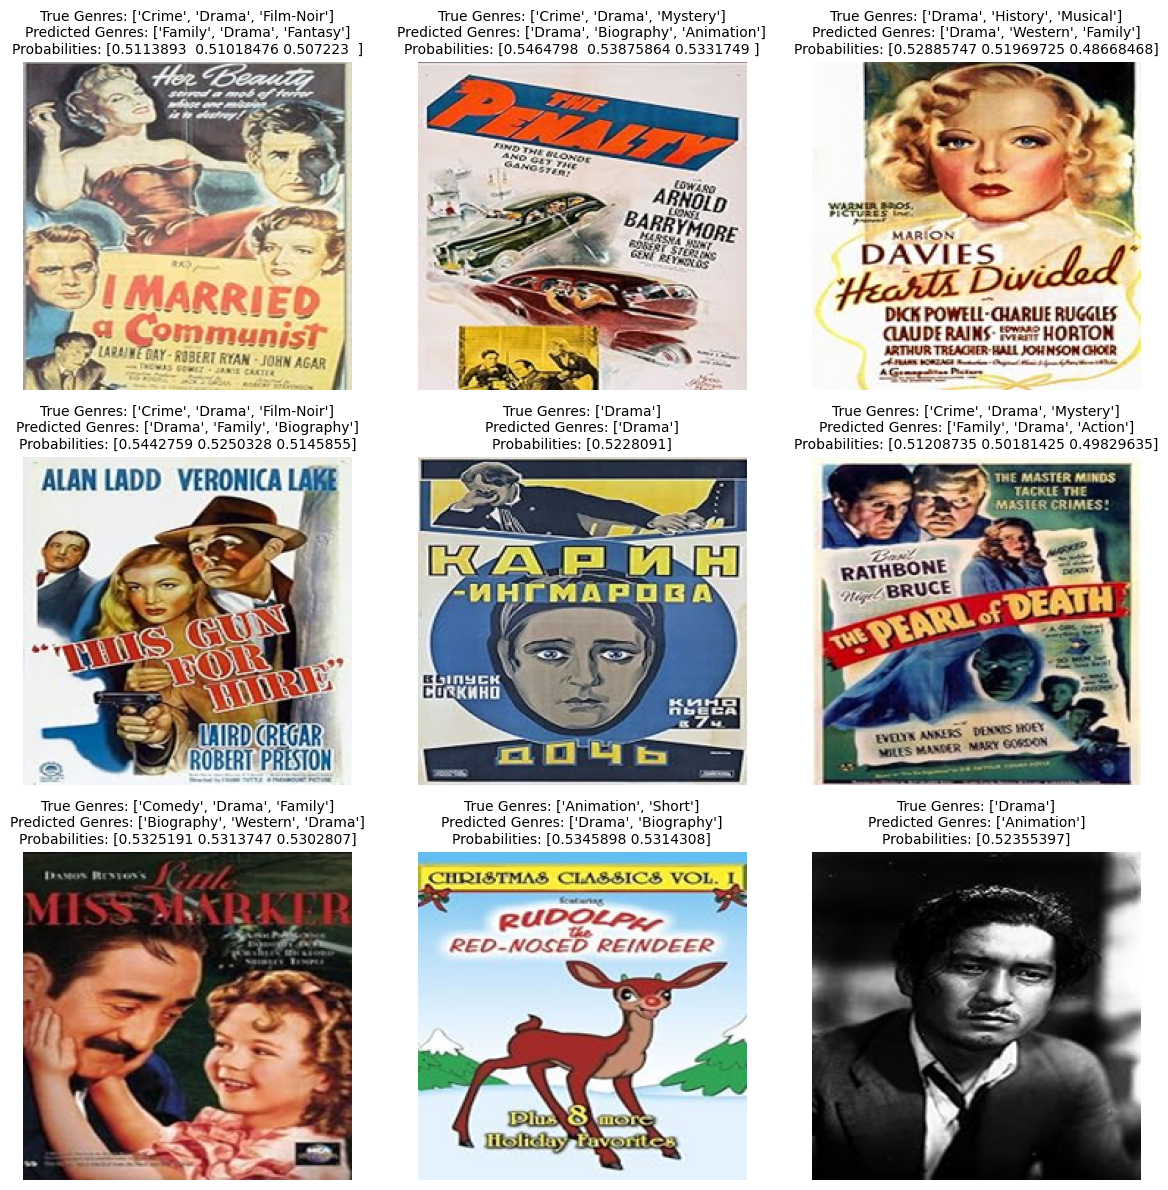

In [12]:
def display(X_test, y_test, predicted_probabilities, binarized_columns, threshold=0.5):
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))

    for idx, ax in enumerate(axes.flat):
        if idx < len(X_test):
            poster = X_test[idx]
            true_labels = [binarized_columns[i] for i, label in enumerate(y_test[idx]) if label == 1]
            predicted_genre_probabilities = predicted_probabilities[idx]

            # Sort predicted probabilities and select labels based on the number of true labels
            num_true_labels = len(true_labels)
            top_predicted_idx = np.argsort(predicted_genre_probabilities)[::-1][:num_true_labels]
            predicted_genre_labels = [binarized_columns[i] for i in top_predicted_idx]
            top_predicted_probabilities = predicted_genre_probabilities[top_predicted_idx]

            ax.imshow(poster)
            ax.set_title(f"True Genres: {true_labels}\nPredicted Genres: {predicted_genre_labels}\nProbabilities: {top_predicted_probabilities}", fontsize=10)
            ax.axis('off')
        else:
            ax.axis('off')  # Hide empty subplots
        
    plt.tight_layout()
    plt.show()

display(X_test, y_test, predicted_probabilities, binarized_columns)